### DDPM

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import math

In [18]:
# Linear Layer Implementation
class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(LinearLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
    
    def forward(self, x):
        output = x @ self.weight.t()
        if self.bias is not None:
            output += self.bias
        return output

# Activation Functions
class ReLU(nn.Module):
    def forward(self, x):
        return torch.maximum(x, torch.zeros_like(x))

class SiLU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Sinusoidal Position Embedding
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

In [19]:
# Improved U-Net Block with proper dimension handling
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, is_upsample=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        
        if is_upsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
            
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.activation = SiLU()
        
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.norm2 = nn.BatchNorm2d(out_channels)
        
        if in_channels != out_channels:
            self.res_conv = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.res_conv = nn.Identity()
    
    def forward(self, x, t_emb):
        # First convolution
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.activation(h)
        
        # Add time embedding
        t_emb = self.time_mlp(t_emb)
        h = h + t_emb[:, :, None, None]
        
        # Second convolution
        h = self.conv2(h)
        h = self.norm2(h)
        h = self.activation(h)
        
        # Residual connection
        return h + self.res_conv(x)

In [ ]:
# Robust DDPM Model with proper dimension handling
class RobustDiffusionModel(nn.Module):
    def __init__(self, image_size=28, channels=1, dim=32, time_emb_dim=128):
        super().__init__()
        self.image_size = image_size
        self.channels = channels
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            LinearLayer(time_emb_dim, time_emb_dim),
            SiLU(),
            LinearLayer(time_emb_dim, time_emb_dim)
        )
        
        # Initial convolution
        self.init_conv = nn.Conv2d(channels, dim, 3, padding=1)
        
        # Encoder path with proper downsampling
        self.enc1 = UNetBlock(dim, dim, time_emb_dim)
        self.enc2 = UNetBlock(dim, dim*2, time_emb_dim)
        self.enc3 = UNetBlock(dim*2, dim*4, time_emb_dim)
        
        # Bottleneck
        self.bottleneck = UNetBlock(dim*4, dim*4, time_emb_dim)
        
        # Decoder path with proper upsamplinп
        self.dec1 = UNetBlock(dim*8, dim*2, time_emb_dim, is_upsample=True)
        self.dec2 = UNetBlock(dim*4, dim, time_emb_dim, is_upsample=True)
        self.dec3 = UNetBlock(dim*2, dim, time_emb_dim, is_upsample=True)
        
        # Final output
        self.final_conv = nn.Sequential(
            nn.Conv2d(dim, dim, 3, padding=1),
            SiLU(),
            nn.Conv2d(dim, channels, 1)
        )
        
        # Pooling and upsampling
        self.pool = nn.AvgPool2d(2)
    
    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_mlp(t)
        
        # Initial convolution
        x0 = self.init_conv(x)
        
        # Encoder with proper downsampling
        e1 = self.enc1(x0, t_emb)                    # 28x28
        e1_pool = self.pool(e1)                      # 14x14
        
        e2 = self.enc2(e1_pool, t_emb)              # 14x14
        e2_pool = self.pool(e2)                      # 7x7
        
        e3 = self.enc3(e2_pool, t_emb)              # 7x7
        e3_pool = self.pool(e3)                      # 3x3
        
        # Bottleneck
        bottleneck = self.bottleneck(e3_pool, t_emb) # 3x3
        
        # Decoder with proper upsampling and skip connections
        # Upsample to match e3 dimensions
        d1 = F.interpolate(bottleneck, size=e3.shape[2:], mode='nearest')  # 7x7
        d1 = torch.cat([d1, e3], dim=1)              # Concatenate along channels
        d1 = self.dec1(d1, t_emb)                    # 7x7
        
        # Upsample to match e2 dimensions
        d2 = F.interpolate(d1, size=e2.shape[2:], mode='nearest')  # 14x14
        d2 = torch.cat([d2, e2], dim=1)              # Concatenate along channels
        d2 = self.dec2(d2, t_emb)                    # 14x14
        
        # Upsample to match e1 dimensions
        d3 = F.interpolate(d2, size=e1.shape[2:], mode='nearest')  # 28x28
        d3 = torch.cat([d3, e1], dim=1)              # Concatenate along channels
        d3 = self.dec3(d3, t_emb)                    # 28x28
        
        # Final output
        return self.final_conv(d3)

In [21]:
# DDPM Trainer
class DDPM:
    def __init__(self, model, timesteps=200, beta_start=1e-4, beta_end=0.02, device='cuda'):
        self.model = model
        self.timesteps = timesteps
        self.device = device
        
        # Linear noise schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
        self.alphas = 1. - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        
        # Pre-calculate values for sampling
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1. - self.alpha_bars)
    
    def sample_timesteps(self, n):
        return torch.randint(0, self.timesteps, (n,), device=self.device)
    
    def noise_images(self, x, t):
        sqrt_alpha_bar = self.sqrt_alpha_bars[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bars[t][:, None, None, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * epsilon, epsilon
    
    def train_step(self, x, optimizer):
        optimizer.zero_grad()
        
        t = self.sample_timesteps(x.shape[0])
        x_noisy, noise = self.noise_images(x, t)
        predicted_noise = self.model(x_noisy, t)
        
        loss = F.mse_loss(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        
        return loss.item()
    
    @torch.no_grad()
    def sample(self, n_samples=16, img_size=28, channels=1):
        self.model.eval()
        x = torch.randn((n_samples, channels, img_size, img_size), device=self.device)
        
        for i in tqdm(reversed(range(self.timesteps)), desc='Sampling'):
            t = torch.full((n_samples,), i, device=self.device, dtype=torch.long)
            predicted_noise = self.model(x, t)
            
            alpha = self.alphas[t][:, None, None, None]
            alpha_bar = self.alpha_bars[t][:, None, None, None]
            beta = self.betas[t][:, None, None, None]
            
            if i > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            
            # DDPM sampling formula
            x = (1 / torch.sqrt(alpha)) * (
                x - ((1 - alpha) / (torch.sqrt(1 - alpha_bar))) * predicted_noise
            ) + torch.sqrt(beta) * noise
        
        self.model.train()
        return torch.clamp(x, -1., 1.)

In [22]:
# Training function
def train_ddpm():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Data preparation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
    
    # Model and trainer
    model = RobustDiffusionModel().to(device)
    ddpm = DDPM(model, device=device, timesteps=200)  # Reduced timesteps for faster training
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Training loop
    epochs = 15
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        model.train()
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for batch_idx, (data, _) in enumerate(progress_bar):
            data = data.to(device)
            loss = ddpm.train_step(data, optimizer)
            epoch_loss += loss
            
            progress_bar.set_postfix({'Loss': f'{loss:.4f}'})
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')
        
        # Sample and save images every 3 epochs
        if (epoch + 1) % 3 == 0:
            samples = ddpm.sample(n_samples=16)
            save_samples(samples, epoch + 1)
    
    return model, ddpm, losses

In [ ]:
def save_samples(samples, epoch, nrow=4):
    samples = samples.cpu()
    samples = (samples + 1) / 2  # Denormalize
    samples = samples.clamp(0, 1)
    
    fig, axes = plt.subplots(nrow, nrow, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        if i < len(samples):
            ax.imshow(samples[i].squeeze(), cmap='gray')
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(f'ddpm_samples_epoch_{epoch}.png')
    plt.close()
    print(f"Saved samples for epoch {epoch}")


def test_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Testing on device: {device}")
    
    model = RobustDiffusionModel().to(device)
    
    # Test with different batch sizes
    batch_sizes = [1, 4, 8]
    
    for batch_size in batch_sizes:
        print(f"\nTesting with batch size {batch_size}:")
        
        # Test forward pass
        x = torch.randn(batch_size, 1, 28, 28).to(device)
        t = torch.randint(0, 200, (batch_size,)).to(device)
        
        try:
            with torch.no_grad():
                output = model(x, t)
            
            print(f"  Input shape: {x.shape}")
            print(f"  Output shape: {output.shape}")
            print(f"  Forward pass successful")
            
            # Test that input and output have same spatial dimensions
            assert x.shape[2:] == output.shape[2:], "Spatial dimensions don't match!"
            print(f"  Spatial dimensions match")
            
        except Exception as e:
            print(f"  Error: {e}")
            return False
    
    print("\n All tests passed! Model architecture is correct.")
    return True

Testing model architecture...
Testing on device: cpu

Testing with batch size 1:
  Input shape: torch.Size([1, 1, 28, 28])
  Output shape: torch.Size([1, 1, 28, 28])
  ✓ Forward pass successful
  ✓ Spatial dimensions match

Testing with batch size 4:
  Input shape: torch.Size([4, 1, 28, 28])
  Output shape: torch.Size([4, 1, 28, 28])
  ✓ Forward pass successful
  ✓ Spatial dimensions match

Testing with batch size 8:
  Input shape: torch.Size([8, 1, 28, 28])
  Output shape: torch.Size([8, 1, 28, 28])
  ✓ Forward pass successful
  ✓ Spatial dimensions match

✓ All tests passed! Model architecture is correct.

Starting training...
Using device: cpu


Epoch 1/15: 100%|██████████| 469/469 [06:44<00:00,  1.16it/s, Loss=0.0720]


Epoch 1, Average Loss: 0.1009


Epoch 2/15: 100%|██████████| 469/469 [06:42<00:00,  1.16it/s, Loss=0.0610]


Epoch 2, Average Loss: 0.0644


Epoch 3/15: 100%|██████████| 469/469 [06:40<00:00,  1.17it/s, Loss=0.0627]


Epoch 3, Average Loss: 0.0582


Sampling: 200it [00:07, 28.34it/s]


Saved samples for epoch 3


Epoch 4/15: 100%|██████████| 469/469 [06:35<00:00,  1.19it/s, Loss=0.0585]


Epoch 4, Average Loss: 0.0555


Epoch 5/15: 100%|██████████| 469/469 [06:30<00:00,  1.20it/s, Loss=0.0544]


Epoch 5, Average Loss: 0.0540


Epoch 6/15: 100%|██████████| 469/469 [06:22<00:00,  1.23it/s, Loss=0.0531]


Epoch 6, Average Loss: 0.0532


Sampling: 200it [00:06, 29.13it/s]


Saved samples for epoch 6


Epoch 7/15: 100%|██████████| 469/469 [06:19<00:00,  1.24it/s, Loss=0.0520]


Epoch 7, Average Loss: 0.0520


Epoch 8/15: 100%|██████████| 469/469 [06:19<00:00,  1.24it/s, Loss=0.0577]


Epoch 8, Average Loss: 0.0506


Epoch 9/15: 100%|██████████| 469/469 [06:51<00:00,  1.14it/s, Loss=0.0507]


Epoch 9, Average Loss: 0.0507


Sampling: 200it [00:09, 21.77it/s]


Saved samples for epoch 9


Epoch 10/15: 100%|██████████| 469/469 [06:43<00:00,  1.16it/s, Loss=0.0485]


Epoch 10, Average Loss: 0.0497


Epoch 11/15: 100%|██████████| 469/469 [07:04<00:00,  1.10it/s, Loss=0.0517]


Epoch 11, Average Loss: 0.0493


Epoch 12/15: 100%|██████████| 469/469 [07:40<00:00,  1.02it/s, Loss=0.0476]


Epoch 12, Average Loss: 0.0485


Sampling: 200it [00:08, 23.40it/s]


Saved samples for epoch 12


Epoch 13/15: 100%|██████████| 469/469 [07:32<00:00,  1.04it/s, Loss=0.0441]


Epoch 13, Average Loss: 0.0486


Epoch 14/15: 100%|██████████| 469/469 [07:05<00:00,  1.10it/s, Loss=0.0622]


Epoch 14, Average Loss: 0.0481


Epoch 15/15: 100%|██████████| 469/469 [07:11<00:00,  1.09it/s, Loss=0.0511]


Epoch 15, Average Loss: 0.0478


Sampling: 200it [00:08, 23.43it/s]


Saved samples for epoch 15


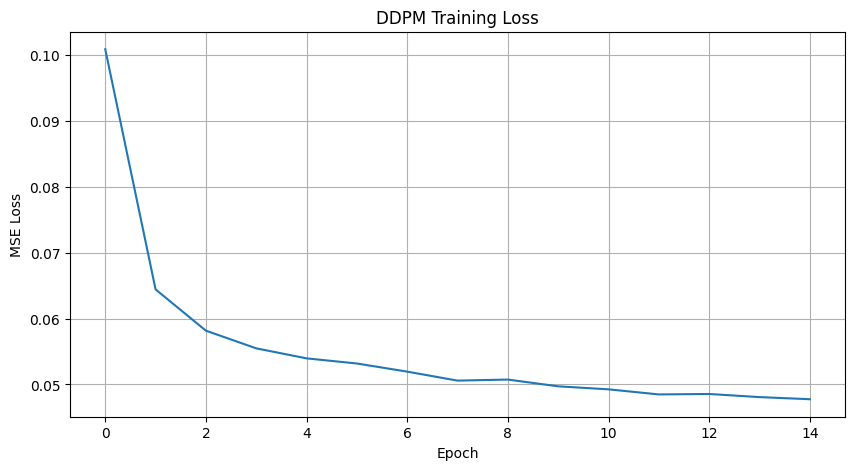

Generating final samples...


Sampling: 200it [00:26,  7.62it/s]


Saved samples for epoch final
Training completed successfully!


In [24]:
if __name__ == "__main__":
    print("Testing model architecture...")
    success = test_model()
    
    if success:
        print("\nStarting training...")
        model, ddpm, losses = train_ddpm()
        
        # Plot training loss
        plt.figure(figsize=(10, 5))
        plt.plot(losses)
        plt.title('DDPM Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.grid(True)
        plt.savefig('ddpm_training_loss.png')
        plt.show()
        
        # Generate final samples
        print("Generating final samples...")
        final_samples = ddpm.sample(n_samples=64)
        save_samples(final_samples, "final")
        
        print("Training completed successfully!")
    else:
        print("Model testing failed. Please check the architecture.")